In [39]:
import matplotlib 
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np
import matplotlib.pyplot as plt
import sys
import time
import math
import datetime
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.metrics import jaccard_score
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('punkt')
from scipy.spatial import distance

print('Python version ' + sys.version)
print('Pandas version ' + pd.__version__)
print('Matplotlib version ' + matplotlib.__version__)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
Python version 3.7.10 (default, Feb 20 2021, 21:17:23) 
[GCC 7.5.0]
Pandas version 1.1.5
Matplotlib version 3.2.2


Drive mount and dataframe initialization

In [40]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [41]:
html_doc=open('/content/drive/MyDrive/Project1/netflix_titles.csv', 'r')
df=pd.read_csv(html_doc)

# Φτιάχνουμε τα missing data για το DataFrame

Αρχίζουμε φτιάχνοντας τα missing data του director και του country, καθώς, μετά απο έλεγχο, είδαμε ότι δεν υπάρχουν missing data για τα type και τα title. Δηλαδή θα πάρουμε την στήλη με τους director και θα σπάσουμε την κάθε συμβολοσιρά ανα γραμμή και τέλος θα βρούμε τους ποιό πολυσύχναστους και θα πάρουμε τον πρώτο και θα το αντικαθιστούμε στις κενές γραμμές. Την ίδια διαδικασία θα ακολουθήσουμε και για τα missing data για την στήλη country.

In [42]:
listD = df[['director']]
listC = df[['country']]

listD['director']=listD['director'].str.split(', ')
listC['country']=listC['country'].str.split(', ')

listD=listD.explode('director').value_counts()
listC=listC.explode('country').value_counts()

director=listD.head(1)
country=listC.head(1)
for i in range(len(df['country'])):

  if pd.isnull(df['director'][i]):
    df['director'][i] = director.index[0][0]
    
  if pd.isnull(df['country'][i]):
    df['country'][i] = country.index[0][0]

Εδώ φτιάχνουμε τα missing data για το cast. Στην ουσία πέρνουμε από το dataframe μας την στήλη του cast, σπάμε τους ηθοποιούς ανα γραμμή και στην συνέχεια πέρνουμε τους πέντε ποιο πολυσύχναστους και τους κάνουμε μια εννοιέα συμβολοσειρά την οποία  τοποθετούμε στις κενές γραμμές.  

In [43]:
listK=df[['cast']]
listK['cast']=listK['cast'].str.split(', ')
listK=listK.explode('cast').value_counts().head(5)
listL=listK.reset_index().drop(columns=0)
cast=listL['cast'].str.cat(sep=', ')

for i in range(len(df['cast'])):
  if pd.isnull(df['cast'][i]):
    df['cast'][i] = cast


Εδώ βρίσκουμε τα missing data για την στήλη data_added. Όπως αναφέρφηκε στο forum για να βρούμε με τι θα προσθέσουμε στα κενά στην στήλη αυτή θα πρέπει να βρούμε την μέση τιμή στις ημερομινίες. Αυτό που κάναμε είναι να πέρνουμε ξεχωριστά την ημερομηνία, τον μήνα και το έτος και να βρίσκουμε για το καθένα ξεχωριστά την μέση τιμή του και στο τέλος να τα προσθέτουμε όλα σε ένα ώστε να έχουμε την συνολική μέση ημερομηνία και να την βάζουμε στα κενά τις στήλης αυτής.  

In [44]:
# Find average date for the DataFrame
date=pd.to_datetime(df['date_added'])
year=date.dt.to_period('M').dt.year
month=date.dt.to_period('M').dt.month
day=date.dt.to_period('D').dt.day
averageY=round(sum(year)/len(year))
averageM=round(sum(month)/len(month))
averageD=round(sum(day)/len(day))
string=str(averageM)+"-"+str(averageD)+"-"+str(averageY)
element = datetime.datetime.strptime(string,"%d-%m-%Y")
timestamp = datetime.datetime.date(element).strftime("%B %d, %Y")

# Insert to DataFrame
for i in range(len(df['date_added'])):
  if pd.isnull(df['date_added'][i]):
    df['date_added'][i] = timestamp

Μετά απο τέστ για το αν υπάρχουν missing data στα release_year βρήκαμε ότι δεν υπάρχουν. Επομένως, προχωράμε στα ratings, στα οποία υπάρχουν. Παρατηρούμε όμως, ότι είναι μόνο 6. Άρα, σύμφωνα και με μια απάντηση στο forum, τα διαγράφουμε, αφού είναι λίγα και δεν θα χάσουμε πολλά data.

In [45]:
for i in range(len(df['rating'])):
  if pd.isnull(df['rating'][i]):
    df=df.drop(index=i)

Μετά απο τέστ για το αν υπάρχουν missing data στα duration, listed_in και στα descption, βρήκαμε ότι δεν υπάρχουν. Επομένως, προχωράμε με τα ερωτήματα.


# Για ερώτημα 1.
*Ποιό είδος υπερτερεί, οι ταινίες ή οι σειρές ;*

1.   Παίρνουμε την στήλη type -> λίστα με όλα τα type που έχουμε.
2.   Μετράμε πόσα υπάρχουν απο κάθε είδος. Ανάλογα τι μας βγάλει, υπερτερεί






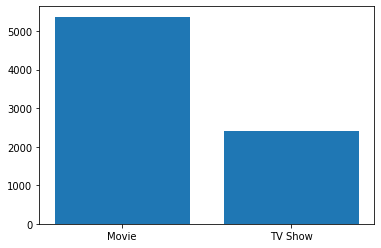

In [46]:
q1 = df['type'].value_counts().reset_index()
q1.columns = ['type', 'count']
types=q1['type']
counts=q1['count']
plt.bar(types, counts)
plt.show()

# Για το ερώτημα 2
*Τα τελευταία χρόνια το netflix επενδύει περισσότερο σε ταινίες ή σε σειρές;*

Σε αυτό το ερώτημα θα πάρουμε τις στήλες type και date_added. Όπου θα φτιάξουμε δύο dictionary ένα για τα Movies και ένα για τα TVshows όπου μέσα  σε μια for με συνθήκες θα βρίσκουμε και θα μετράμε για κάθε dictionary την κάθε χρονιά πόσες σειρές ή ταινίες έχει. Και στο τέλος θα φτιάξουμε ένα γράφημα και για τα δύο ώστε να βλέπουμε για κάθε χρονιά σε τι επενδύει το netflix.  


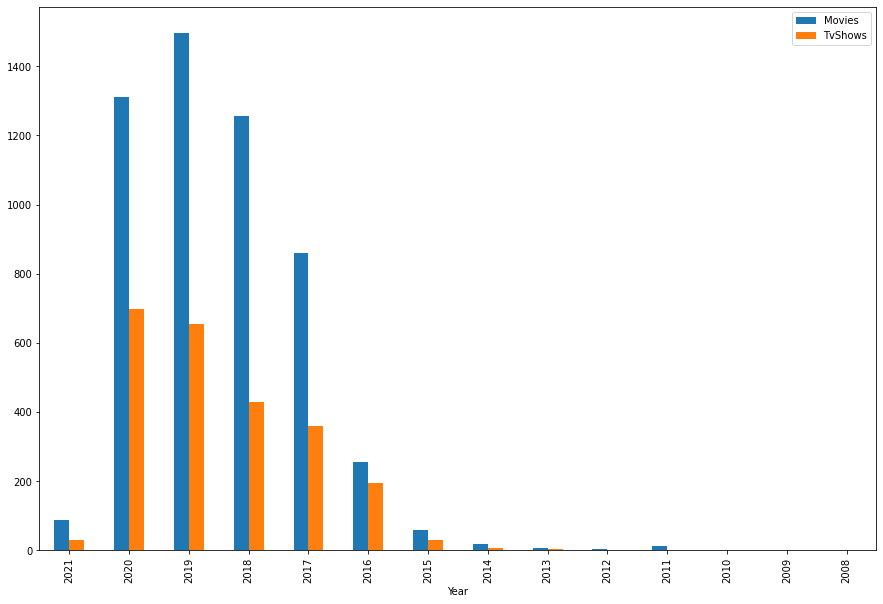

In [47]:
types=df['type']
# Take from date_added the year and make a list with all the types
date=pd.to_datetime(df['date_added']).dt.to_period('M')
date=date.dt.year
average=round(sum(date)/len(date))

zip2=zip(types, date)
list2=list(zip2)
movies=dict() # year, count
tvshow=dict() # year, count
for word in list2:
  if word[0]=='Movie':
    
    if word[1] in movies:
      movies[word[1]]+=1
    else:
      movies[word[1]]=1

  elif word[0]=='TV Show':
    
    if word[1] in tvshow:
      tvshow[word[1]]+=1
    else:
      tvshow[word[1]]=1


q2=pd.DataFrame(movies.items(), columns=['Year', 'Movies'])
q2_new=pd.DataFrame(tvshow.items(), columns=['Year', 'TvShows'])
frames=[q2, q2_new]
result=pd.merge(q2, q2_new, how="outer", on='Year')
result=result.sort_values(by='Year', ascending=False)
result=result.set_index('Year')
bar=result.plot.bar(figsize=(15,10))

# Για το ερώτημα 3

*Ποιά χώρα έχει το περισσότερο περιεχόμενο;*

Αν κάνουμε το country τύπου list, παίρνουμε όλες τις χώρες, χωρίς "..."

list(df['country'])

Εδώ πέρνουμε την στήλη country και μετράμε πόσες φορές εμφανίζονται οι ίδιες γραμμές και με την  reset_index () ορίζουμε μια λίστα με ακέραιο αριθμό από 0 έως το μήκος δεδομένων ως ευρετήριο και την κάνουμε λίστα. Επειδή σε κάποια σειρά έχουμε πολλές χώρες θα τις διασπάσουμε ώστε να τις πάρουμε ξεχωριστά. Θα φτιάξουμε ένα dictonary όπου με βάση αυτό θα πάρουμε τις 10 πιο συχνές εμφανιζόμενες χώρες διότι θα ήταν αδύνατον να φτιάξουμε ένα ιστόγραμα με το να δίχνει όλες τις χώρες και για αυτό πέρνουμε να συγκρίνουμε με βάση τις δέκα πρώτες.  



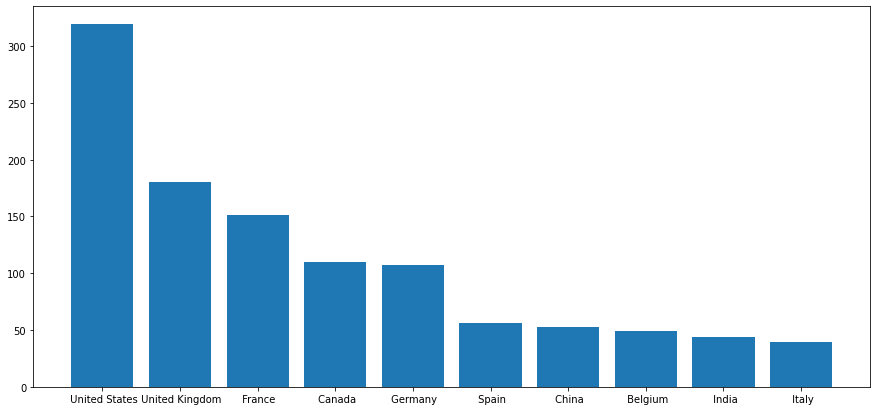

In [48]:
# make a list of the countries
list3 = df['country'].value_counts().reset_index()

list3=list(list3['index'])
# make a string and join at the ", "
splt=', '.join(list3)

# split the string at the ,
splt=splt.split(",")

# find how many entries each country has
q3=dict()
for word in splt:
  if word == '':
    continue
  if word in q3:
    q3[word]+=1
  else:
    q3[word]=1
# sort the dictionary and make a dataframe out of it
q3=dict(sorted(q3.items(), key=lambda item:item[1], reverse=True))
q3=pd.DataFrame(q3.items(), columns=['Country', 'Count'])
# take the 10 most used countries and make a graph out of them
q3=q3.head(10)
types=q3['Country']
counts=q3['Count']
plt.figure(figsize=(15, 7))
plt.bar(types, counts)
plt.show()

# Για το ερώτημα 4

*Τι είδους περιεχόμενο έχει κάθε χώρα;*

Έχουμε πάρει τις στήλες country, listed_in, show_id και τις επεξεργαζόμαστε με παρόμοιο τρόπο όπως προαναφέραμε και παραπάνω και στην συνέχεια δημιουργούμε με αυτές ένα πίνακα όπου αναπαριστούνται country, listed_in, show_id . Στην συνέχεια ομαδοποιόυμε ανά χώρα και με την εντολή get_group('...') και με παράμετρο κάποιο όνομα χώρας που θα βάλουμε θα μας επιστρέψει τι είδος περιεχόμενο έχει. 

In [49]:
list4= df[['country', 'listed_in', 'show_id']].reset_index()

country=list4[['country', 'show_id']]
genre=list4[['listed_in', 'show_id']]

country['country']=country['country'].str.split(', ')  #type as list
genre['listed_in']=genre['listed_in'].str.split(', ') #type as list 

country=country.explode('country')
genre=genre.explode('listed_in')

newdf=pd.merge(country, genre, on='show_id', how="outer")
newdf=newdf.set_index('show_id')

newdf=newdf.groupby('country')
newdf.get_group('Greece').listed_in

show_id
s2300          British TV Shows
s2300                Docuseries
s2300    International TV Shows
s2301                    Movies
s2302                    Movies
s3664                    Dramas
s3664        Independent Movies
s4081        Action & Adventure
s4081          Sci-Fi & Fantasy
s6279             Documentaries
s6279              LGBTQ Movies
s6354                    Dramas
s6354        Independent Movies
s6374                    Dramas
s6609                  Comedies
s6609      International Movies
s6609           Romantic Movies
s6637          British TV Shows
s6637                Docuseries
s6637       Science & Nature TV
Name: listed_in, dtype: object

# Για το ερώτημα 5

*Ετοιμάστε γραφήματα που δειχνουν τους ηθοποιούς με τις περισσότερες ταινίες σε
κάθε χώρα. Κάντε το ίδιο και για τις σειρές*

Αρχικά, παίρνουμε το cast, show_id και type απο το dataframe. Στην συνέχεια τα χωρίζουμε ανάλογα με το type. Δηλαδή, σε ταινίες και σε σειρές. Μετά, παρατηρούμε ότι σε κάθε ταινία εργάζονται παραπάνω απο ένας ηθοποιοί, επομένως, διασπάμε το column cast, έτσι ώστε να παίρνουμε ξεχωριστά τον κάθε ηθοποιό. Μετά, χρησιμοποιούμε το country του προηγούμενου ερωτήματος για να αντιστοιχήσουμε τα show_id με τις χώρες στις οποίες προβάλονται. Έτσι, έχουμε στο τέλος, 2 DataFrame, το CountryMovies και το CountryTvShow, τα οποία αντιστοιχούν σε ηθοποιούς και σε ποίες χώρες παίζουν. Από αυτά προκύπτουν τα ανάλογα γραφήματα.

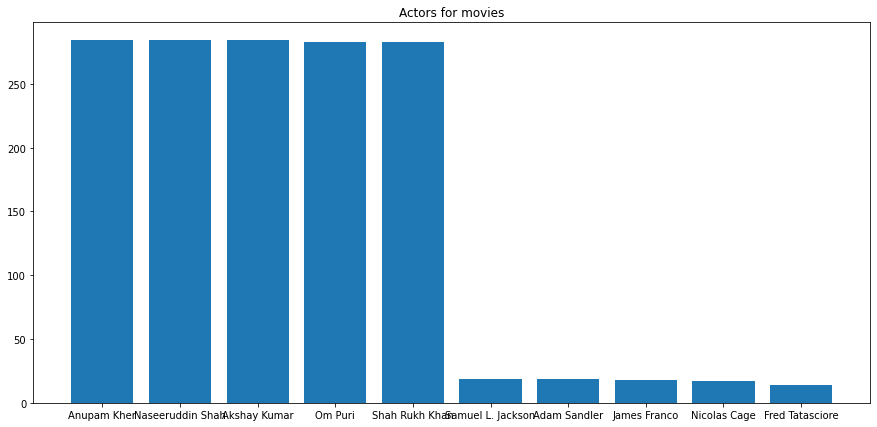

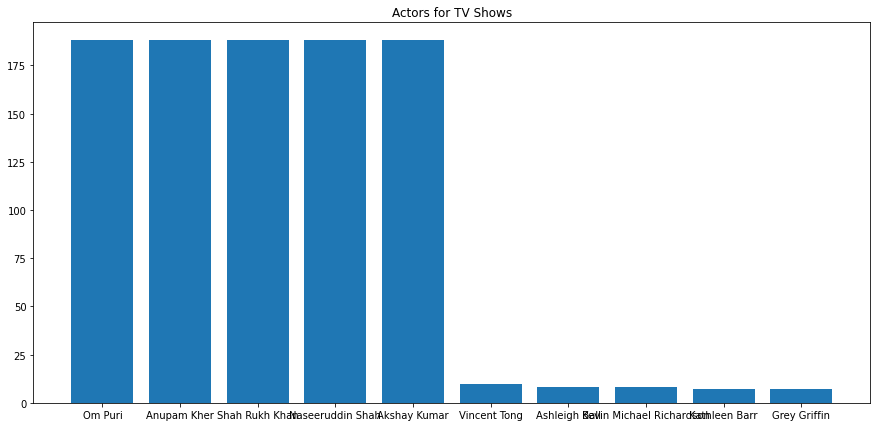

In [50]:
list5 = df[['cast', 'show_id', 'type']]
list5 = list5.groupby('type')

movies = list5.get_group('Movie') # All movies with the show_id and their cast
tvshows = list5.get_group('TV Show') # All tvshows with the show_id and their cast
# Also, we have the country and the show_id's that correspond to them from the previous exercise

movies['cast']=movies['cast'].str.split(', ')  # cast as list
movies=movies.explode('cast') # Break the cast list and make new rows

tvshows['cast']=tvshows['cast'].str.split(', ')  #cast as list
tvshows=tvshows.explode('cast') # Break the cast list and make new rows

CountryMovies=pd.merge(movies, country, on='show_id')
CountryTvShow=pd.merge(tvshows, country, on='show_id')

CountryTvShow=CountryTvShow.drop(columns=['type', 'show_id'])
CountryTvShow=CountryTvShow.groupby(['cast', 'country'])['cast'].count()

CountryMovies=CountryMovies.drop(columns=['type', 'show_id'])
CountryMovies=CountryMovies.groupby(['cast', 'country'])['cast'].count()

CountryName='United States' # We can change this

CountryMovies=CountryMovies.sort_values(ascending=False)
CountryMovies=CountryMovies.reset_index(level='country')
CountryMovies.columns=['country', 'count']
CountryMovies=CountryMovies.groupby('country')
CountryMovies=CountryMovies.get_group(CountryName).head(10)

types=CountryMovies.index
counts=CountryMovies['count']
plt.figure(figsize=(15, 7))
plt.title("Actors for movies")
plt.bar(types, counts)
plt.show()

CountryTvShow=CountryTvShow.sort_values(ascending=False)
CountryTvShow=CountryTvShow.reset_index(level='country')
CountryTvShow.columns=['country', 'count']
CountryTvShow=CountryTvShow.groupby('country')
CountryTvShow=CountryTvShow.get_group(CountryName).head(10)

types=CountryTvShow.index
counts=CountryTvShow['count']
plt.figure(figsize=(15, 7))
plt.title("Actors for TV Shows")
plt.bar(types, counts)
plt.show()

# Για την ερώτηση 6

*Το netflix υποστηρίζει ότι παρέχει πλούσιο περιεχόμενο για όλες τις ηλικίες.
Αληθεύει αυτό; Φτιάξτε ένα γράφημα το οποίο συγκεντρώνει το πλήθος των
ταινιων ανάλογα με την προτεινόμενη ηλικία (αναφερόμαστε στη στήλη rating). Τα
όρια καθορίζονται σύμφωνα με τον παρακάτω πίνακα. Κάντε το ίδιο γράφημα και
για τις σειρές*

Παίρνουμε απο το DataFrame τα type και τα rating και τα χωρίζουμε σε ταινίες και σειρές, ανάλογα απο το type. Στην συνέχεια, κάνουμε 4 πίνακες όπου χωρίζουμε τα rating σύμφωνα με τον πίνακα που μας δίνεται. Έτσι, στο τέλος προσθέτουμε 4 rows στα καινούργια μας DataFrame(movies και tvshow) στα οποία ανάλογα με την κατηγορία στην οποία υπάγεται το rating, προσθέτουμε το count. Απο αυτά τα 4 rows, και για τα movies αλλά και για τα tvshows, προκύπτει το παρακάτω γράφημα.


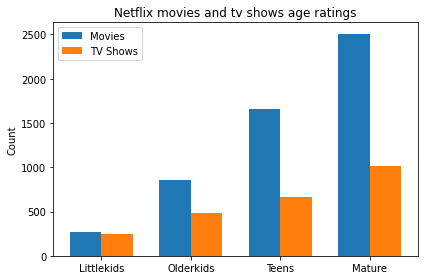

<Figure size 720x720 with 0 Axes>

In [51]:
list6 = df[['type', 'rating']]
list6=list6.set_index('type')

movies=list6.drop(index='TV Show')
tvshow=list6.drop(index='Movie')

movies=movies.groupby('rating')['rating'].count()
tvshow=tvshow.groupby('rating')['rating'].count()

littlekids=['G', 'TV-Y', 'TV-G']
olderkids=['PG', 'TV-Y7', 'TV-Y7-FV', 'TV-PG']
teens=['PG-13', 'TV-14']
mature=['R', 'NC-17', 'TV-MA']

movies['littlekids']=0
movies['olderkids']=0
movies['teens']=0
movies['mature']=0
for rating in movies.index:
  if rating in littlekids:
    movies['littlekids']+=movies.loc[rating]
  elif rating in olderkids:
    movies['olderkids']+=movies.loc[rating]
  elif rating in teens:
    movies['teens']+=movies.loc[rating]    
  elif rating in mature:
    movies['mature']+=movies.loc[rating]

tvshow['littlekids']=0
tvshow['olderkids']=0
tvshow['teens']=0
tvshow['mature']=0
for rating in tvshow.index:
  if rating in littlekids:
    tvshow['littlekids']+=tvshow.loc[rating]
  elif rating in olderkids:
    tvshow['olderkids']+=tvshow.loc[rating]
  elif rating in teens:
    tvshow['teens']+=tvshow.loc[rating]    
  elif rating in mature:
    tvshow['mature']+=tvshow.loc[rating]

movierating=[movies.loc['littlekids'], movies.loc['olderkids'], movies.loc['teens'], movies.loc['mature']]
tvshowrating=[tvshow.loc['littlekids'], tvshow.loc['olderkids'], tvshow.loc['teens'], tvshow.loc['mature']]


# Bar settings
x=np.arange(4)
width=0.35
fig, ax=plt.subplots()
rect1=ax.bar(x-width/2, movierating, width, label="Movies")
rect2=ax.bar(x+width/2, tvshowrating, width, label="TV Shows")

ax.set_ylabel('Count')
ax.set_title('Netflix movies and tv shows age ratings')
ax.set_xticks(x)
ax.set_xticklabels(['Littlekids', 'Olderkids', 'Teens', 'Mature'])
ax.legend()

fig.tight_layout()
plt.figure(figsize=(10, 10))
plt.show()

# Για την ερώτηση 7

*Αν ένας παραγωγός ήθελε να έχει υψηλή ακροαματικότητα, σκέφτεται ότι θα ήταν
ίσως καλύτερα να βγάλει την ταινία του σε μία εποχή που δεν υπάρχει
ανταγωνισμός. Κάντε ένα γράφημα με το περιεχόμενο που προστίθεται ανά μήνα
για να τον βοηθήσετε να επιλέξει τη σωστή χρονική περίοδο.*

Παίρνουμε την στήλη date_added και από αυτήν παίρνουμε μόνο τους μήνες. Στην συνέχεια, τους ομαδοποιούμε και τους μετράμε, και με βάση τα αποτελέσματα που πέρνουμε φτιάχνουμε το γράφημα.

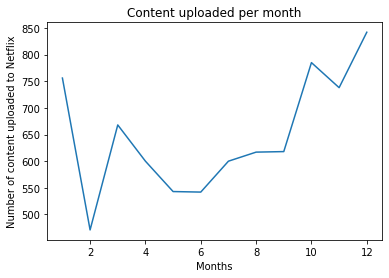

In [52]:
list7=pd.to_datetime(df['date_added'])
month=list7.dt.to_period('M').dt.month
month=month.groupby(month.values).count()

plt.plot(month.index, month.values)
plt.xlabel('Months')
plt.ylabel('Number of content uploaded to Netflix')
plt.title('Content uploaded per month')
plt.show()

# Για την ερώτηση 8

*Ετοιμάστε ένα γράφημα που παρουσιάζει συγκεντρωτικά τα είδη του περιεχομένου
(αναφερόμαστε στη στήλη listed_in).*

Εδώ πέρνουμε την στήλη listed_in από το datafreame μας. Διασπάμε την κάθε γραμμή και στην συνέχεια ομαδοποιούμε τα ίδια, τα μετράμε και τα ταξινομούμε με αύξουσα σειρά και με βάση αυτά βγαίνει το παρακάτω γράφημα.   

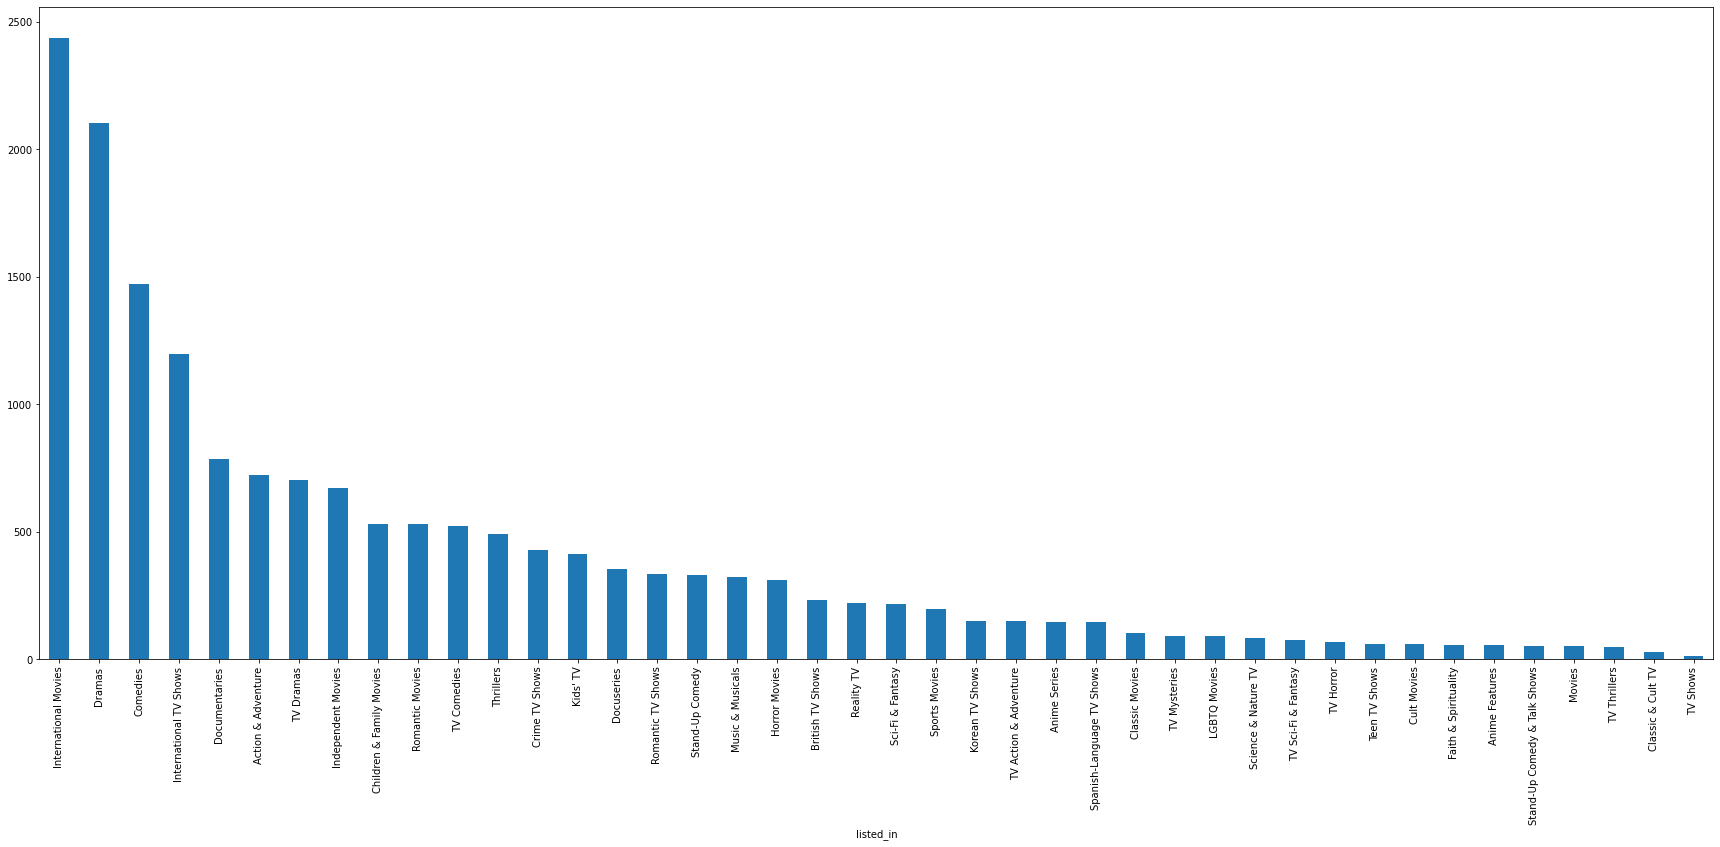

In [53]:
list8=df[['listed_in']]
list8['listed_in']=list8['listed_in'].str.split(', ') #type as list 
list8=list8.explode('listed_in')
list8=list8.groupby('listed_in')['listed_in'].count()
list8=list8.sort_values(ascending=False)
list8.plot.bar(figsize=(30,12))

# Για την ερώτηση 9

*Μελετηστε τους σκηνοθέτες ανά χώρα και παρουσιάστε σχετικά γραφήματα*

Παίρνουμε απο το DataFrame μας τα country και το director. Παρατηρούμε ότι ανα ταινία υπάρχουν πολλοί σκηνοθέτες και πολλές χώρες. Επομένως, τα διασπάμε και είναι όλα ξεχωρίστα. Έτσι, βρίσκουμε τα τον αριθμό των σκηνοθετών που έχει κάθε χώρα και τον αριθό των ταινιών, για τους 10 πρώτους σκηνοθέτες για μια χώρα. Για να δούμε διαφορετικές χώρες, αλλάζουμε το CountryName και το τρέχουμε

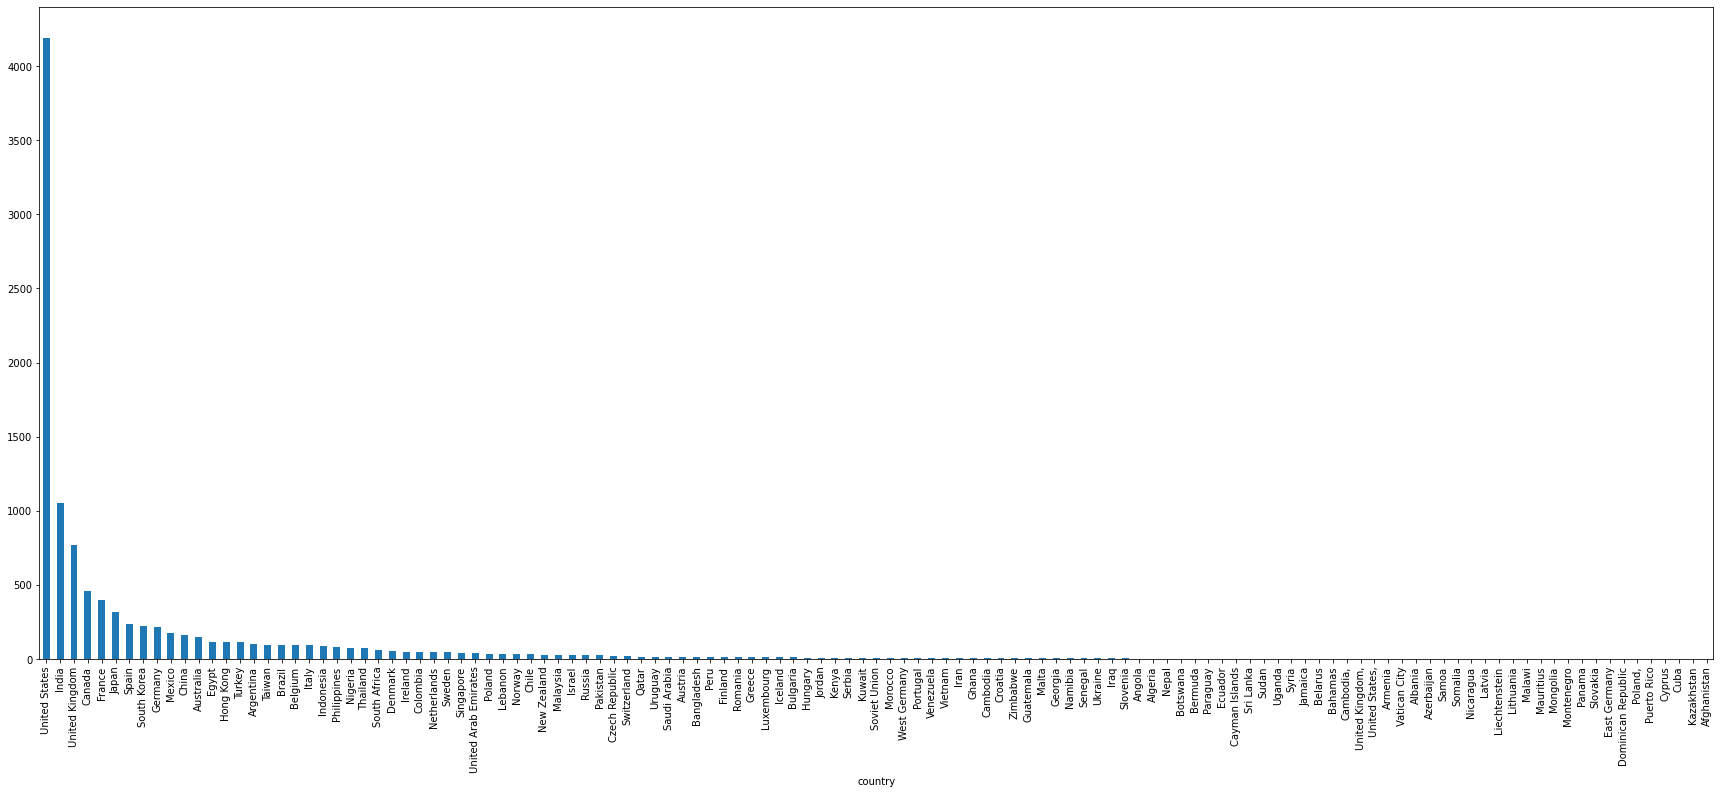

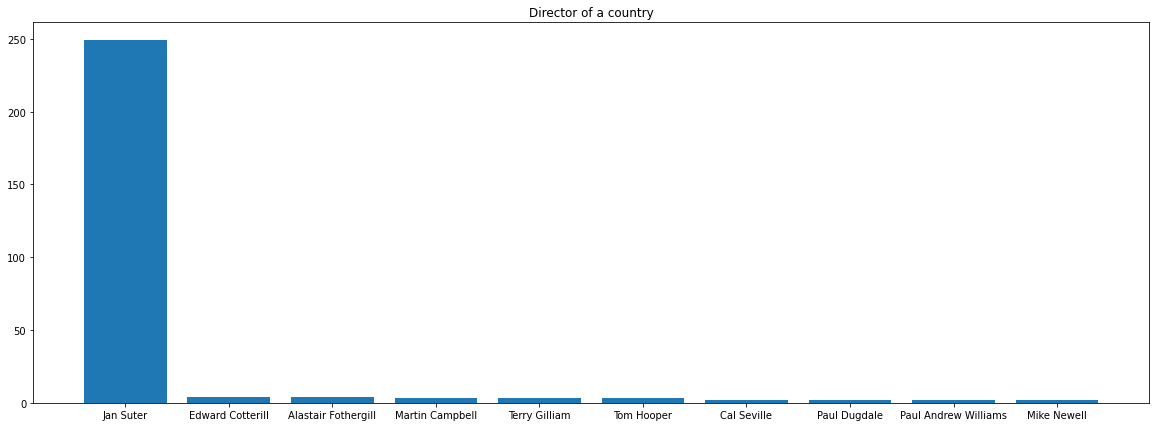

In [54]:
list9=df[['country', 'director']]

list9['country']=list9['country'].str.split(', ') #type as list 
list9['director']=list9['director'].str.split(', ') #type as list 

list9=list9.explode('country')
list9=list9.explode('director')

# First Graph: Directors per country
graph1=list9.drop_duplicates(subset=['country', 'director'])
graph1=list9.groupby('country')['country'].count()
graph1=graph1.sort_values(ascending=False)
graph1.plot.bar(figsize=(30,12))

# Second Graph: Directors of a country
CountryName='United Kingdom' # We can change this

graph2=list9.groupby(['director', 'country'])['director'].count()
graph2=graph2.sort_values(ascending=False)
graph2=graph2.reset_index(level='country')
graph2.columns=['country', 'count']
graph2=graph2.groupby('country')
graph2=graph2.get_group(CountryName).head(10)

types=graph2.index
counts=graph2['count']
plt.figure(figsize=(20, 7))
plt.title("Director of a country")
plt.bar(types, counts)
plt.show()

# Για την ερώτηση 10

*Μελετήστε τις σειρές και παρουσιάστε ένα γράφημα που τις δείχνει ανάλογα με το
αριθμό των seasons.*

Εδώ παίρνουμε τις στήλες type και duration από το datafreame μας. Θέτουμε το index του ευρετηρίου μας να είναι η type. Στην συνέχεια διώχνουμε τα movies και τα ομαδοποιούμε, τα μετράμε και τα ταξινομούμε με αύξουσα σειρά και με βάση αυτά βγαίνει το παρακάτω ιστόγραμμα.

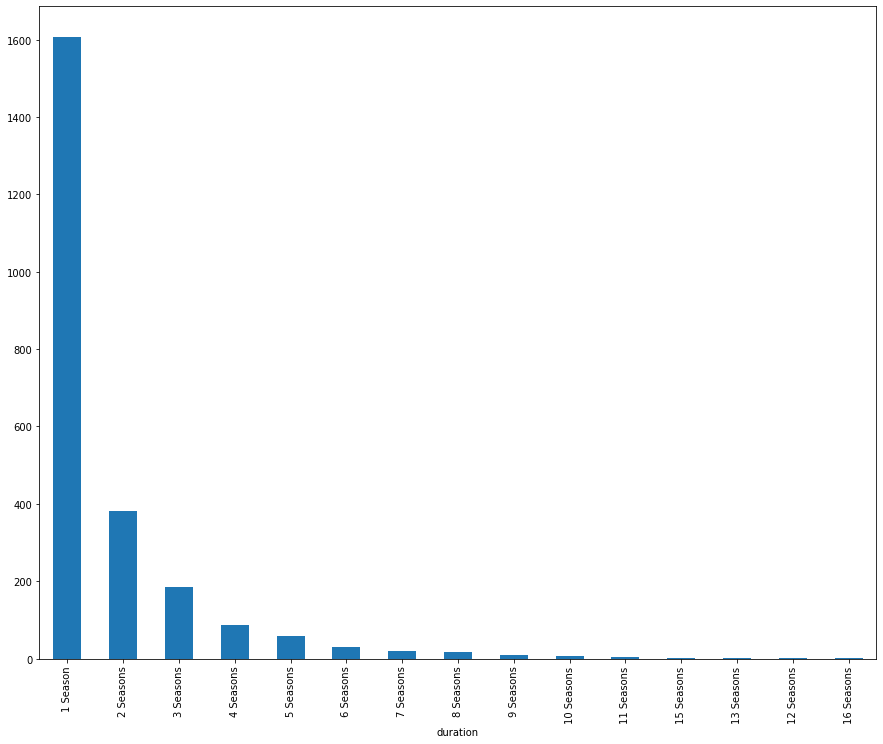

In [55]:
list10=df[['type','duration']]
list10=list10.set_index('type')
list10=list10.drop(index='Movie')
season=list10.groupby('duration')['duration'].count()
season=season.sort_values(ascending=False)
season.plot.bar(figsize=(15,12))
plt.show()

# Για το ερώτημα 11

*Αξιοποιήστε τα υπόλοιπα αρχεία της εργασίας για να απαντήσετε στο ερώτημα:
Ποιές είναι οι ταινίες με την πιο υψηλή βαθμολογία; Θα χρειαστεί να συννενώσετε
κατάλληλα τα αρχεία που σας δίνονται ώστε να κρατήσετε τις ταινίες του netflix για τις οποίες υπάρχουν ratings στο IMBD*

Απο το αρχικό μας DataFrame, παίρνουμε τα type και title, απο το df_movies, το οποίο περιέχει τις ταινίες του imdb, παίρνουμε τα imdb_title_id και title και απο το df_rating, το οποίο περιέχει τις κριτηκές για τις ταινίες, παίρνουμε τα imdb_title_id, weighted_average_vote και median_vote. Έτσι, έχουμε και το weighted average, το οποίο μας φαίνεται πιο πιθανό να δούμε να αναγράφεται σε μια σελίδα όπως το imdb αλλά, και το πραγματικό μέσο όρο. Στην συνέχεια, κάνουμε merge τα 3 αυτά DataFrame που έχουμε δημιουργήσει, και καταλήγουμε σε ένα DataFrame(df11), το οποίο έχει όλες τις ταινίες του netflix που υπάρχουν στο imdb, μαζί με το weighted_average και το median_vote τους. Επομένως, κάνοντας τους sort σύμφωνα και με τις 2 αυτές τιμές, φτιάχνουμε το γράφημα μας, το οποίο μας δείχνει ποιές ταινίες έχουν καλές κρητικές και με τους 2 τρόπους υπολογισμού.

In [56]:
html_doc=open('/content/drive/MyDrive/Project1/IMDb movies.csv', 'r')
df_movies=pd.read_csv(html_doc)

html_doc=open('/content/drive/MyDrive/Project1/IMDb ratings.csv', 'r')
df_rating=pd.read_csv(html_doc)

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (3) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


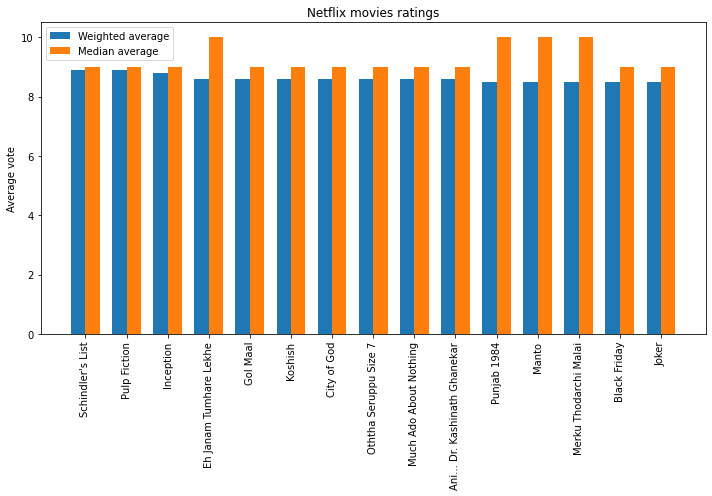

In [57]:
list11=df[['type', 'title']]
list11=list11.set_index('type')
list11=list11.drop(index='TV Show')

imdb_movies=df_movies[['imdb_title_id', 'title']]
imdb_ratings=df_rating[['imdb_title_id', 'weighted_average_vote', 'median_vote']]

imdb=pd.merge(imdb_movies, imdb_ratings, on='imdb_title_id')
imdb=imdb.drop(columns=['imdb_title_id'])

df11=pd.merge(imdb, list11, on='title')

df11=df11.sort_values(by=['weighted_average_vote', 'median_vote'], ascending=False)
df11=df11.head(15)
df11=df11.set_index('title')

# Bar settings
x=np.arange(15)
width=0.35
fig, ax=plt.subplots(figsize=(10, 7))
rect1=ax.bar(x-width/2, df11.weighted_average_vote, width, label="Weighted average")
rect2=ax.bar(x+width/2, df11.median_vote, width, label="Median average")

ax.set_ylabel('Average vote')
ax.set_title('Netflix movies ratings')
ax.set_xticks(x)
ax.set_xticklabels(df11.index, rotation='vertical')
ax.legend()

fig.tight_layout()
plt.show()

# **Part 2**


Φτιάχνουμε το "γενικό" DataFrame απο το οποίο θα παίρνουμε στοιχεία απο δω και πέρα.

In [58]:
# Make the wanted dataframe
df2=df[['show_id', 'title', 'description', 'type']]
df2=df2.set_index('type')
df2=df2.drop(index='TV Show')
df2=df2.reset_index()

# Για το ερώτημα 1.a.

*Δημιουργήστε το boolean BoW πίνακα των unigrams και των bigrams από τη
κειμενική αναπαράσταση των ταινιών. (χρησιμοποιήστε την παράμετρο
ngram_range του CountVectorizer).*

Χρησιμοποιούμε την CountVectorizer, όπως μας λέτε και στην εκφώνηση, και τις συναρτήσεις fit_transform, todense, tolist και get_feature_names για την "αποκωδικοποιηση" των description. Το LemmaTokenizer το βρήκαμε να καλείται έτσι [εδώ](https://scikit-learn.org/stable/modules/feature_extraction.html). Στο strip_accents χρησιμοποιήσαμε unicode γιατί μπορεί να μην έχουμε μόνο ASCII χαρακτήρες στα description. Το lowercase το ενεργοποιήσαμε γιατί κάποιες λέξεις ήταν και με μικρά και με κεφαλαία. Το binary και το ngram_range τα κάναμε σύμφωνα με οδηγίες σας. Ενώ, τα όρια του min_df και max_df τα θέσαμε μετά απο της οδηγίες του κ.Γουνόπουλου να έχουμε μικρό vocabulary. Έτσι, ψάχναμε να βρούμε την καλύτερη λύση, και την βρήκαμε μέσα σε αυτό το όριο. Γιατί έχει 505 λέξεις και δεν κατά κύριο λόγο δεν είναι "άχρηστες". Στο τέλος, κάνουμε ένα DataFrame(BoW) στο οποίο έχουμε όλες τις πληροφορίες που πήραμε.

In [59]:
# Make the unigram and bigram with BoW
corpus = df2['description']

class LemmaTokenizer:
     def __init__(self):
         self.wnl = WordNetLemmatizer()
     def __call__(self, doc):
         return [self.wnl.lemmatize(t) for t in word_tokenize(doc) if t not in stopwords.words('english')]

vectorizer = CountVectorizer(tokenizer=LemmaTokenizer(), strip_accents='unicode', min_df=0.005, max_df=0.1, binary=True, ngram_range=(1, 2), stop_words='english', lowercase=True)
X = vectorizer.fit_transform(corpus)
dense=X.todense()
denselist=dense.tolist()
vocabularybow=vectorizer.get_feature_names()
print(len(vocabularybow))
BoW = pd.DataFrame(denselist, columns=vocabularybow, dtype=int)
BoW = BoW.merge(df2, right_index=True, left_index=True)
BoW = BoW.drop(columns=['description', 'type', 'show_id'])
BoW = BoW.set_index(['title'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


505


# Για το ερώτημα 1.b.

*Δημιουργήστε τον TF-IDF (Term Frequency - Inverse Document Frequency)
πίνακα των unigrams και των bigrams από τη κειμενική αναπαράσταση των
ταινιών.*

Κάνουμε τα ίδια με πρίν. Η μόνη διαφορά είναι ότι δεν έχουμε binary στην TfidVectorizer.Στο τέλος, κάνουμε ένα DataFrame(tf) στο οποίο έχουμε όλες τις πληροφορίες που πήραμε.

In [60]:
tfidf = TfidfVectorizer(tokenizer=LemmaTokenizer(), strip_accents='unicode', min_df=0.005, max_df=0.1, ngram_range=(1, 2), stop_words='english', lowercase=True)
vect = tfidf.fit_transform(corpus)

vocabularytf = tfidf.get_feature_names() # Get all the words from the corpus
dense=vect.todense()
denselist=dense.tolist()
tf = pd.DataFrame(denselist, columns=vocabularytf)
tf = tf.merge(df2, right_index=True, left_index=True)
tf = tf.drop(columns=['description', 'type', 'show_id'])
tf = tf.set_index(['title'])

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


# Για το ερώτημα 2.a

*Για την αναπαράσταση από το 1.α, θα αξιοποιήσετε το Jaccard/Tanimoto
coefficient για να υπολογίσετε την ομοιότητα 2 ταινιών δοθέντων των feature
vectors τους.*

Για την jaccard_coefficient χρησιμοποιούμε την jacard_score η οποία, επιστρέφει την τιμή του jaccard coefficient.

In [61]:
def jaccard_coefficient(df_A, df_B):
  return jaccard_score(df_A, df_B)

# Για το ερώτημα 2.b

*Για την αναπαράσταση από το 1.β, θα αξιοποιήσετε το cosine similarity.*

Η distance.cosine(df_A, df_B) υπολογίζει την cosine απόσταση. Επομένως, για να πάρουμε την cosine similarity κάνουμε, 1-distance.cosine(df_A, df_B)

In [62]:
def cosine_similarity(df_A, df_B):
  return 1-distance.cosine(df_A, df_B)

# Για το ερώτημα 3

*Πρόβλεψη (1): Φτιάξτε μία συνάρτηση η οποία παίρνει σαν είσοδο ένα τίτλο, ένα
ακέραιο αριθμό N και τον τρόπο εύρεσης της ομοιότητας (boolean ή tf-idf σύμφωνα
με τα 1,2) και επιστρέφει τους Ν πιο όμοιους τίτλους*

Για την υλοποίηση της συνάρτησης αυτής, στην αρχή ελέγχουμε τι μέθοδο μας έχει δώσει στην κλήση ο χρήστης και αναλόγως παίρνουμε την ταινία που θέλουμε απο το κατάλληλο DataFrame. Στην συνέχεια δημιουργούμε ένα καινούργιο DataFrame, το similar, στο οποίο κρατάμε τον τίτλο της ταινίας την οποίο ελέγχουμε για την ομοιότητα της με αυτή που μας έδωσε ο χρήστης και το ποσοστό της ομοιότητας τους. Μετά, κάνει τους ελέγχους μέσα σε μια λούπα. Τρέχει για όλους τους τίτλους και αναλόγως καλεί την jaccard_coefficient ή την cosine_similarity. Στο τέλος, ταξινομεί το DataFrame σύμφωνα με την τιμή του similarity και εκτυπώνει τις N πρώτες τιμές.

In [63]:
def get_similar_movies1(Title, N, method):
  
  if method=='boolean':
    ninth_title=df2['title']
    A=BoW.loc[Title]
  elif method=='tf-idf':
    ninth_title=df2['title']
    A=tf.loc[Title]

  similar=pd.DataFrame(columns=['Title', 'Similarity']) # TitleA = Title that the use gives
  
  for i in ninth_title:

    if i == Title:
      continue
    if method=='boolean':
      B=BoW.loc[i]
      Sim=jaccard_coefficient(df_A=A, df_B=B)
    elif method=='tf-idf':
      B=tf.loc[i]
      Sim=cosine_similarity(df_A=A, df_B=B)

    similar=similar.append({'Title': i, 'Similarity':Sim}, ignore_index=True)
  similar=similar.sort_values(by='Similarity', ascending=False)
  print(similar.head(N))

# Για το ερώτημα 4

*Πρόβλεψη (1): Φτιάξτε μία συνάρτηση η οποία παίρνει σαν είσοδο ένα τίτλο, ένα
ακέραιο αριθμό N και τον τρόπο εύρεσης της ομοιότητας (boolean ή tf-idf σύμφωνα
με τα 1,2) και επιστρέφει τους Ν πιο όμοιους τίτλους*

Για αυτό το ερώτημα εργαζόμαστε πάνω-κάτω όπως πρίν. Δηλαδή, πάλι ελέγχουμε όλους τους τίτλους σύμφωνα με την κατάλληλη μέθοδο και στο τέλος τα βάζουμε σε ένα καινούργιο DataFrame, απο το οποίο εκτυπώνουμε τις Ν πρώτες τιμές, αφού το ταξινομήσουμε. Όμως, μια μεγάλη διαφορά που έχουν οι 2 αυτές συναρτήσεις είναι ότι, εδώ παίρνουμε το Description και το κάνουμε "αποκωδικοποίηση" αναλόγως την μέθοδο που θα χρησιμοποιήσουμε. Στην συνέχεια, το βάζουμε σε ένα καινούργιο DataFrame και εκεί κάνουμε concat το DataFrame που αντιστοιχεί στην μέθοδο που θέλει να χρησιμοποιήσει ο χρήστης, BoW ή tf. Μετά παίρνουμε σαν πρώτο στοιχείο το row που έχει τίτλο " " καθώς, αυτό έχουμε δώσει στο Description πιο πριν. Μετά κάνουμε κανονικά, όπως πρίν, τον έλεγχο και την εισαγωγή στο καινούργιο DataFrame(similar).

In [64]:
def get_similar_movies2(Description, N, method):

  corpus=[Description]
  if method=='boolean':
    titles=BoW.index
    vectorizerA = CountVectorizer(tokenizer=LemmaTokenizer(), strip_accents='unicode', binary=True, ngram_range=(1, 2), stop_words='english', lowercase=True)
    XA = vectorizerA.fit_transform(corpus)
    denseA=XA.todense()
    denselistA=denseA.tolist()
    vocabularybowA=vectorizerA.get_feature_names()
    df3=pd.DataFrame(denselistA, columns=vocabularybowA, dtype=int)
    df3['title']=" "
    df3=df3.set_index('title')
    df3=pd.concat([df3, BoW]).fillna(0)
  elif method=='tf-idf':
    titles=tf.index
    tfidfA = TfidfVectorizer(tokenizer=LemmaTokenizer(), strip_accents='unicode', ngram_range=(1, 2), stop_words='english', lowercase=True)
    vectA = tfidfA.fit_transform(corpus)
    denseA=vectA.todense()
    denselistA=denseA.tolist()
    vocabularytfA = tfidfA.get_feature_names()
    df3=pd.DataFrame(denselistA, columns=vocabularytfA)
    df3['title']=" "
    df3=df3.set_index('title')
    df3=pd.concat([df3, tf]).fillna(0)

  similar2=pd.DataFrame(columns=['Title', 'Similarity']) 
  A=df3.loc[" "]
  for i in titles:

    if method=='boolean':
      B=df3.loc[i]
      Sim=jaccard_coefficient(df_A=A, df_B=B)
    elif method=='tf-idf':
      B=df3.loc[i]
      Sim=cosine_similarity(df_A=A, df_B=B)

    similar2=similar2.append({'Title': i, 'Similarity':Sim}, ignore_index=True)
  similar2=similar2.sort_values(by='Similarity', ascending=False)
  print(similar2.head(N))

# Απο εδώ και κάτω εκτελούμε κάποιες ενδεικτικές κλήσεις των συναρτήσεων


In [65]:
get_similar_movies1(Title='187', N=20, method='boolean')
get_similar_movies1(Title='187', N=20, method='tf-idf')

                                   Title  Similarity
1241                          Dilan 1990    0.416667
1250                           Dismissed    0.416667
4745              The School of Mischief    0.384615
4240                        The Bad Kids    0.384615
364         American Pie 9: Girls' Rules    0.357143
36                         1 Mile to You    0.333333
741                         Blue Jasmine    0.333333
1030                         Cloverfield    0.333333
570                                Barry    0.312500
5246                          White Girl    0.312500
1731            Good Game: The Beginning    0.307692
5063                          Uncut Gems    0.307692
4750           The Secret Life of Pets 2    0.307692
1340                              Easy A    0.307692
4367                        The Detained    0.307692
4287                       The Brave One    0.294118
3077                   Natural Selection    0.285714
235                      Across The Line    0.

/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


                                           Title  Similarity
1250                                   Dismissed    0.637916
4240                                The Bad Kids    0.622842
4745                      The School of Mischief    0.573245
1241                                  Dilan 1990    0.567829
364                 American Pie 9: Girls' Rules    0.526919
5064                                  Undefeated    0.524909
3490  Quiet Victory: The Charlie Wedemeyer Story    0.508482
4367                                The Detained    0.489086
4705                          The Rainbow Troops    0.486708
4675                               The Physician    0.477630
1731                    Good Game: The Beginning    0.472899
4522                 The Knight Before Christmas    0.467377
1032                                Coach Carter    0.464540
4282                  The Boy Who Cried Werewolf    0.460727
36                                 1 Mile to You    0.452288
3077                    

To "After a devastating earthquake hits Mexico City" είναι απο το description της ταινίας με τίτλο "7:19". Το βάλαμε για να δείξουμε ότι δείχνει σωστά την ομοιότητα όταν υπάρχει. To άλλο το βάλαμε γιατί δεν θα υπάρχουν τα ονόματα μας σε κάποιο descritpion. Έτσι, θέλουμε να δείξουμε ότι βγάζει σωστά αποτελέσματα και όταν δεν υπάρχει κάποια ομοιότητα.

In [66]:
get_similar_movies2(Description='After a devastating earthquake hits Mexico City', N=100, method='tf-idf')
get_similar_movies2(Description='After a devastating earthquake hits Mexico City', N=100, method='boolean')

get_similar_movies2(Description='Dimitris Diakatos Manos Anastasakis', N=100, method='tf-idf')
get_similar_movies2(Description='Dimitris Diakatos Manos Anastasakis', N=100, method='boolean')

/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


                                           Title  Similarity
0                                           7:19    0.491374
3598                                      Rezeta    0.368621
1372  El Especial de Alex Fernández, el Especial    0.308175
2992                   Mutiny of the Worker Bees    0.278942
190                       A Tale of Two Kitchens    0.274477
...                                          ...         ...
3498                                       Rabun    0.129743
1035                                      Code 8    0.129655
4751                   The Secret Life of Pets 2    0.129488
3920                      Sincerely Yours, Dhaka    0.128684
4412                             The Flintstones    0.128557

[100 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


                                           Title  Similarity
0                                           7:19    0.300000
3598                                      Rezeta    0.181818
1372  El Especial de Alex Fernández, el Especial    0.166667
190                       A Tale of Two Kitchens    0.153846
2992                   Mutiny of the Worker Bees    0.153846
...                                          ...         ...
27                                     #Rucker50    0.071429
1035                                      Code 8    0.071429
4412                             The Flintstones    0.066667
3634                                   Rock On!!    0.066667
2353          Kevin James: Sweat the Small Stuff    0.066667

[100 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
/usr/local/lib/python3.7/dist-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


                                               Title  Similarity
0                                               7:19         0.0
3586                                         Results         0.0
3584                                         Residue         0.0
3583                                       Residente         0.0
3582                        Resident Evil: Afterlife         0.0
...                                              ...         ...
3660  Ron White: If You Quit Listening, I'll Shut Up         0.0
3659                                          Romina         0.0
3658                                    Romeo Ranjha         0.0
3657                              Romeo Akbar Walter         0.0
3656               Romantik Komedi 2: Bekarlığa Veda         0.0

[100 rows x 2 columns]


/usr/local/lib/python3.7/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['le', 'u'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


                                               Title  Similarity
0                                               7:19         0.0
3588                                         Retablo         0.0
3586                                         Results         0.0
3585                 Restless Creature: Wendy Whelan         0.0
3584                                         Residue         0.0
...                                              ...         ...
3661                        Ronnie Coleman: The King         0.0
3660  Ron White: If You Quit Listening, I'll Shut Up         0.0
3659                                          Romina         0.0
3658                                    Romeo Ranjha         0.0
3657                              Romeo Akbar Walter         0.0

[100 rows x 2 columns]
